In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../") # Add parent directory to path
from mfbox import gokunet_df_ratio
from scipy.interpolate import interp1d

In [13]:
# Check if GPU is available
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [14]:
zs_obj = [0, 0.2, 0.5, 1, 2, 3]
# remove duplicates
zs_obj = np.unique(zs_obj)

In [15]:
# load input data
x_test = np.loadtxt("../data/muse_H/train_input.txt")
lgk_test = np.loadtxt("../data/muse_H/kf.txt")
k_test = 10**lgk_test

n_k = len(lgk_test)
n_z = len(zs_obj)

# normalize input data
# bounds = np.loadtxt("../data/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/input_limits.txt")
bounds_path = "../data/input_limits-W.txt"
# x_test = (x_test - bounds[:,0]) / (bounds[:,1] - bounds[:,0])

y_test = np.loadtxt("../data/muse_H/train_output.txt")
# reshape y_test to match the number of k values and z values
# y_test = y_test[:, i_z*n_k:(i_z+1)*n_k]
y_test = y_test.reshape(-1, n_z, n_k)

y_test = 10**y_test

ind_h = [24, 25, 26, 54, 55, 56, 72, 73, 74, 207, 208, 209, 240, 241, 242, 300, 301, 302, 522, 523, 524]


lgk_l2 = np.loadtxt("../data/muse_L2/kf.txt")
k_l2 = 10**lgk_l2
n_k_l2 = len(lgk_l2)
y_l2 = np.loadtxt("../data/muse_L2/train_output.txt")
y_l2 = 10**y_l2[ind_h]
y_l2 = y_l2.reshape(-1, n_z, n_k_l2)




In [16]:
y_test.shape

(21, 6, 64)

In [17]:
def power_ratio(k, y_pred, k_test, y_test):

    # find the indices of k_common in k_test
    k_indices = np.where((k_test >= k.min()) & (k_test < k.max()))[0]
    k_common = k_test[k_indices]
    y_test_common = y_test[k_indices]

    # interpolate the values of y_pred at the k_common points in log space
    f = interp1d(np.log10(k), np.log10(y_pred), axis=0, kind='linear')
    y_pred_interp = f(np.log10(k_common))
    # convert back to linear space
    y_pred_interp = 10**y_pred_interp

    # calculate the ratio
    ratio = y_pred_interp / y_test_common
    print("y_test_common", y_test_common)
    print("y_pred_interp", y_pred_interp)

    return k_common, ratio


In [18]:


def rel_MAEs(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    ind_com = np.where((log10_x1 >= common_log10_x_min) & (log10_x1 <= common_log10_x_max) )

    common_log10_x = log10_x1[ind_com]

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.abs((interp_y2 / interp_y1) - 1)
    return common_x, rMAE_y

def rMAE_av_cosmo(k_test, y_test, k_pred, y_pred, exclude=None):
    Ps_pred = y_pred
    Ps_sim = y_test
    k_sim = k_test
    k, rAEs = rel_MAEs(k_sim, Ps_sim, k_pred, Ps_pred)
    if exclude is not None:  # exclude some cosmologies
        rAEs = np.delete(rAEs, exclude, axis=0)
    rMAE_av = np.mean(rAEs, axis=0)

    # rAE_av_k = np.mean(rAEs, axis=1)

    # min and max
    rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
    return k, rMAE_av, rMAE_min, rMAE_max, rAEs

In [19]:
# loop over all k-folds to get the prediction
y_h2_pred = []
kfolds = 21

for i in range(kfolds):
    emu = gokunet_df_ratio(path_LF="../models/muse-All-2_L2/model_fold{}.pth".format(ind_h[i]), path_LHr="../models/muse-HO-2_L2Hr/model_fold{}.pth".format(i), bounds_path=bounds_path, device=device)
    # emu = gokunet_test(path_LA="../models/L1A/model_fold{}.pth".format(ind_h[i]),path_HA="../models/LHAr/model_fold{}.pth".format(i), path_L2="../models/L2/model_fold{}.pth".format(ind_h[i]), path_LH="../models/LHr_stitch/best_model.pth".format(i), bounds_path=bounds_path)
    _, y_h2_pred_temp = emu.predict(x_test)
    y_h2_pred.append(y_h2_pred_temp[i])

y_h2_pred = np.array(y_h2_pred)
y_h2_pred = y_h2_pred.reshape(-1, n_z, n_k_l2)


y_pred shape torch.Size([21, 50])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 118])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 50])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 118])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 50])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 118])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 50])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 118])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 50])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 118])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 50])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 118])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 50])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21, 118])
y_pred shape torch.Size([21, 384])
y_pred shape torch.Size([21

In [20]:
from matplotlib import patches


average over k: 0.007267487681354589
average over k: 0.0066145047880208285
average over k: 0.006565767138451821
average over k: 0.0058721483073258685
average over k: 0.005488582978740277
average over k: 0.0054885682296333255


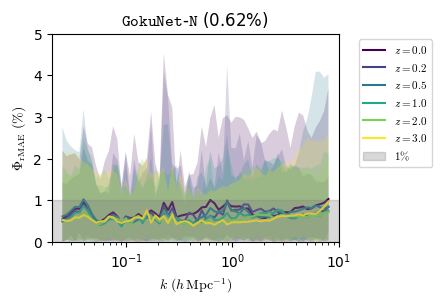

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3.7, 2.7))

# plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'


# zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
# a = 1/(1+zs)
rMAE_cosmos = []

cmap = "viridis"
cmap = plt.get_cmap(cmap)
color_list = [x for x in cmap(np.arange(len(zs_obj))/(len(zs_obj)-1))]

for i in range(len(zs_obj)):
    c = color_list[i]

    k_com, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(k_test, y_test[:,i], k_l2, y_h2_pred[:,i], exclude=None)
    # rMAE_zs.append(rMAE.mean())
    # plot all cosmologies
    # for j in range(rAEs.shape[0]):
    #     ax.plot(k_com, rAEs[j]/1e-2, color=c, alpha=0.1)

    
    ax.fill_between(k_com, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')

    ax.plot(k_com, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs_obj[i])

    print('average over k:', rMAE.mean())
    rMAE_cosmos.append(rMAE.mean())

rMAE_cosmos = np.array(rMAE_cosmos)
    

# title
ax.set_title(r'$\tt{GokuNet}$'+'-'+r'$\tt{N}$' + f' ({100*rMAE_cosmos.mean():.2f}%)')


ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 5)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square1 = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 1, color='gray', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# Add the square to the axes
ax.add_patch(square1)
# ax.add_patch(square1)
# ax.legend(loc='upper left')
# move the legend to outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)


# plt.show()
# plt.savefig('loo_against_W.pdf', bbox_inches='tight')

In [22]:
rMAE_cosmos_zs = []

for i in range(len(zs_obj)):

    k_com, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(k_test, y_test[:,i], k_l2, y_h2_pred[:,i], exclude=None)
    # rMAE_zs.append(rMAE.mean())
    # plot all cosmologies
    # for j in range(rAEs.shape[0]):
    #     ax.plot(k_com, rAEs[j]/1e-2, color=c, alpha=0.1)
    rMAE_cosmos_zs.append(rAEs)

rMAE_cosmos_zs = np.array(rMAE_cosmos_zs)

rMAE_worst_cosmo = rMAE_cosmos_zs.mean(axis=0).mean(axis=1).max()

print("Worst cosmology rMAE:", rMAE_worst_cosmo)

Worst cosmology rMAE: 0.011486807915299067
